In [5]:
from Code_utilities.VideoUtilities.VideoToNumpy import VideoToNumpy
from Code_utilities.DataPlotter import DataPlotter
from Code_utilities.VideoUtilities.AmplitudeSpectralDensityCalculator import AmplitudeSpectralDensityCalculator
from Code_utilities.DataFitter import DataFitter
from Code_utilities.SeriesAnalyzer_2 import SeriesAnalyzer_2
from Code_utilities.BeamAnalysis import BeamAnalysis
import matplotlib.pyplot as plt

plt.close('all')


class NEPCalculator:
    def __init__(self, ):
        ''''Relevant parameters for analysis'''
        self.video_path = (
            '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz Camera/20250616/NEC/video')
        self.power_series_path = (
            '/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/DataAnalysis/Low cost THz Camera/20250603/NEC_PowerSeries/all_measurements')
        self.camera_name = 'NEC'
        self.pixel_block_size_for_asd_average = 100

        self.angle_pol_voltage_measurement_NEC = 90
        self.measured_voltage_converted_from_lock_in_to_osciloscope_V_NEC = 1.05
        self.moved_pol = 'first'
        # x_center_NEC = 152 - 1
        # y_center_NEC = 122
        x_center_NEC = 122
        y_center_NEC = 223
        width = 41

        self.crop_x_range_NEC = (x_center_NEC - width / 2, x_center_NEC + width / 2)
        self.crop_y_range_NEC = (y_center_NEC - width / 2, y_center_NEC + width / 2)

        if self.camera_name == 'HIKMICRO':
            self.frame_rate = 25
        if self.camera_name == 'NEC':
            self.frame_rate = 30

        #self.asd_at_1hz=self.get_asd_at_1hz()

    def plot_asd(self):
        frames_array = VideoToNumpy(video_path=self.video_path,
                                    camera_name=self.camera_name).frames

        AmplitudeSpectraDensity = AmplitudeSpectralDensityCalculator(
            frames_array,
            frame_rate_Hz=self.frame_rate,
            pixel_block_size=self.pixel_block_size_for_asd_average,
            visualize_region=True,
        shift_crop_region_x=-50,
        shift_crop_region_y=-100,)

        freqs, mean_asd = AmplitudeSpectraDensity.freqs, AmplitudeSpectraDensity.mean_asd

        Plot = DataPlotter()

        fig, ax, asd_1hz = Plot.plot_asd_figure(freqs=freqs,
                                                mean_asd=mean_asd,
                                                bool_print_asd_at_1hz=False, )

        return fig, ax, asd_1hz

    def get_asd_at_1hz(self):
        _, _, asd_1hz = self.plot_asd()
        return asd_1hz

    def plot_map_example(self,
                         filename):
        crop_x_range_NEC = self.crop_x_range_NEC
        crop_y_range_NEC = self.crop_y_range_NEC
        HIKMICRO_dir_path = self.power_series_path

        beam_analysis_NEC = BeamAnalysis(dir_path=HIKMICRO_dir_path,
                                         signal_filename=filename,
                                         camera_name=self.camera_name,
                                         crop_range_x_pixels=crop_x_range_NEC,
                                         crop_range_y_pixels=crop_y_range_NEC)
        fig_NEC, ax_NEC = beam_analysis_NEC.plot_map_in_pixels()
        return fig_NEC, ax_NEC

    def get_responsivity(self):

        crop_x_range_NEC = self.crop_x_range_NEC
        crop_y_range_NEC = self.crop_y_range_NEC
        angle_pol_voltage_measurement_NEC = self.angle_pol_voltage_measurement_NEC
        measured_voltage_converted_from_lock_in_to_osciloscope_V_NEC = self.measured_voltage_converted_from_lock_in_to_osciloscope_V_NEC
        moved_pol = self.moved_pol
        HIKMICRO_dir_path = self.power_series_path

        HIKMICRO_SeriesAnalyzer = SeriesAnalyzer_2(dir_path=HIKMICRO_dir_path,
                                                   camera_name=self.camera_name,
                                                   Y_ref_position_for_background_subtraction=3,
                                                   crop_range_x_pixels=crop_x_range_NEC,
                                                   crop_range_y_pixels=crop_y_range_NEC)

        beam_characterization_df_NEC = HIKMICRO_SeriesAnalyzer.get_beam_char_df_w_powers(save_data_plot_bool=True,
                                                                                         known_angle=angle_pol_voltage_measurement_NEC,
                                                                                         known_voltage_at_known_angle_in_V=measured_voltage_converted_from_lock_in_to_osciloscope_V_NEC,
                                                                                         moved_polarizer=moved_pol, )

        fig_fitting_NEC, ax_fitting_NEC = DataFitter().plot_data_with_fit_for_paper(
            x_data=beam_characterization_df_NEC['Power (uW)'],
            y_data=beam_characterization_df_NEC['total_intensity'],
            x_label=r'Power (uW)',
            y_label='Intensity (a.u.)',
            title=self.camera_name,
            camera_name=self.camera_name,
        )
        fitting_coefficients_NEC_all_together = DataFitter().get_fitting_coefficients(x_data=
                                                                                      beam_characterization_df_NEC[
                                                                                          'Power (uW)'],
                                                                                      y_data=
                                                                                      beam_characterization_df_NEC[
                                                                                          'total_intensity'], )
        responsivity_degrees_uW = fitting_coefficients_NEC_all_together[0]

        return responsivity_degrees_uW

    def calculate_NEP(self):
        self.responsivity_degrees_uW = self.get_responsivity()
        self.asd_1hz = self.get_asd_at_1hz()

        NEP_uW_srqHz = self.asd_1hz / self.responsivity_degrees_uW

        uW_to_pW = 10 ** 6
        NEP_pW_srqHz = NEP_uW_srqHz * uW_to_pW

        return NEP_pW_srqHz




Detecting CSV format from 20250616_154510_317_001_10_01_10.csv...
Using config: sep=',', decimal='.'
Loading 309 frames in parallel...
Successfully loaded 309 frames.
Visualizing cropped region, saving maps to cropped_region_analysis.pdf ...
Successfully saved region maps to cropped_region_analysis.pdf
Calculating ASD for 10000 pixels in a 100x100 block...


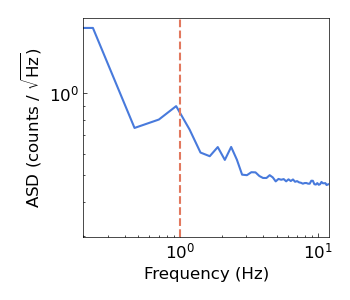

In [6]:
%matplotlib widget
NEPCalculator = NEPCalculator()
fig_asd, ax_asd, asd_1hz = NEPCalculator.plot_asd()
ax_asd.set_xlim(0.2,
                12)
ax_asd.set_ylabel(f'ASD (counts / $\\sqrt{{\\mathrm{{Hz}}}}$)')
fig_asd.tight_layout()
fig_asd.savefig('/Users/Shared/Files From c.localized/Gabriel_UniBern_Local/Manuscripts/Low THz Camera MS/Figures/SI/ASD/'+NEPCalculator.camera_name + '_ASD.pdf')

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Map'}, xlabel='x (pixels)', ylabel='y (pixels)'>)

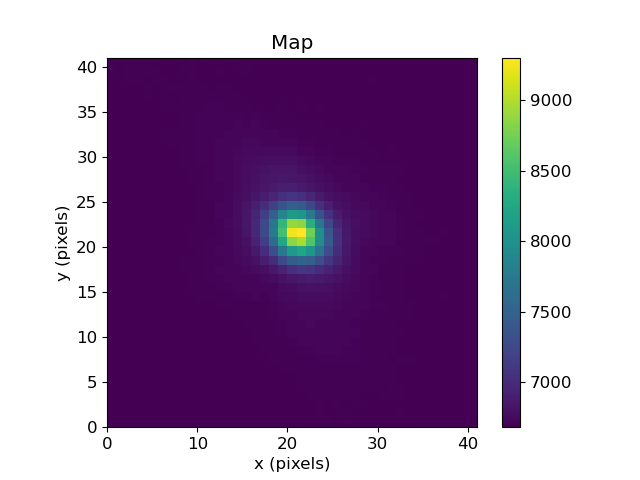

In [7]:

NEPCalculator.plot_map_example(filename='50 degrees.csv')

Moved first polarizer


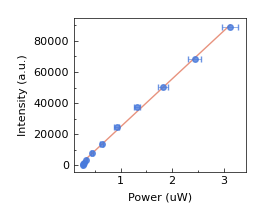

Moved first polarizer


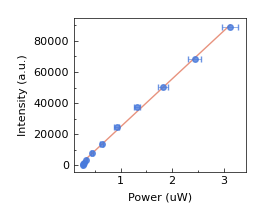

Detecting CSV format from 20250616_154510_317_001_10_01_10.csv...
Using config: sep=',', decimal='.'
Loading 309 frames in parallel...
Successfully loaded 309 frames.
Visualizing cropped region, saving maps to cropped_region_analysis.pdf ...
Successfully saved region maps to cropped_region_analysis.pdf
Calculating ASD for 10000 pixels in a 100x100 block...


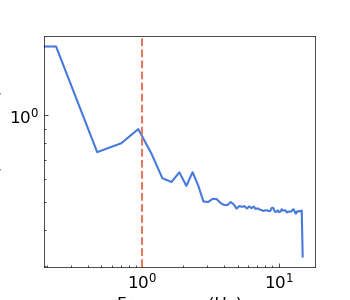

In [8]:
responsivity=NEPCalculator.get_responsivity()
NEP_pW_srqHz=NEPCalculator.calculate_NEP()
